# Env reward scaling - pettingzoo

Acts as a testbed for academics using 2 or 3d shaped data. 

Scales using MovingFoldChangeReward. 

### Background
In Dualer models I put reward and intrinsic rewards in competition. This means the two values must be matched up. Or put another way, that need to have common units. There are many ways to do that. Let's consider a biological motivated approach to reward normalization inspired by:

    - Adler, M., and Alon, U. (2018). Fold-change detection in biological
    systems. Current Opinion in Systems Biology 8, 81–89.
    - Karin, O., and Alon, U. (2021). The dopamine circuit as a reward-taxis navigation system. BioRxiv 439955, 30.

We'll try several `envs`

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import gym
import numpy as np
import torch as th

from copy import deepcopy
from collections import defaultdict

import pettingzoo
from pettingzoo import mpe
import supersuit as ss

from infoduel_maddpg.utils.academic_wrappers import StatePrediction
from infoduel_maddpg.utils.normalize_wrappers import ClipReward
from infoduel_maddpg.utils.normalize_wrappers import MovingFoldChangeReward

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline

## Scratch pad
Playing with various fold-change implementationss to handle sign changes and other inconveniences.

In [ ]:
import numpy as np

x = np.linspace(-500, 1000, 10000)
ref = -200

def fold_change1(x, ref):
    delta = x - ref
    fold = delta / ref
    signs = np.sign(ref)
    fold = fold * signs
    return fold

def fold_change2(x, ref):
    delta = x - ref
    signs = np.sign(delta)
    fold = np.abs(delta) / np.abs(ref)
    fold = np.log10(fold)
    return fold #* signs

def sigmoid(x):
    return 1 / (1 + np.exp(-x*.5))

# print(x, fold_change(x, ref))
plt.figure()
plt.plot(x, fold_change1(x, ref), '.', color="blue")
plt.axhline(0, color='k')
plt.axhline(0, color='k')
plt.axvline(ref, color='k')

plt.figure()
plt.plot(x, sigmoid(fold_change1(x, ref)) - 0.5, '.', color="green")
plt.axhline(0, color='k')
plt.axhline(0, color='k')
plt.axvline(ref, color='k')

# Init

In [3]:
env_name = "simple_v2"
# env_name = "simple_tag_v2"

In [13]:
seed = 50
total_timesteps = 25000
lr_academic = 0.001
do_fold = True
do_clip = False

# Init Env

In [22]:
Env = getattr(mpe, env_name)
env = Env.parallel_env(continuous_actions=True)

academic = Env.parallel_env(continuous_actions=True)
academic = StatePrediction(
        academic,
        network_hidden=[64],
        lr=lr_academic,
        device="cpu",
    )
    
# Fold-change?
if do_fold:
    env  = MovingFoldChangeReward(
        env, 
        intial_reference_reward=-2, 
        bias_reward=0, 
    )
    academic = MovingFoldChangeReward(
        academic, 
        intial_reference_reward=0.01, 
        bias_reward=0, 
    )
# Clip?
if do_clip:
    env = ClipReward(env, min_reward=-100, max_reward=100)
    academic = ClipReward(academic, min_reward=-100, max_reward=100)

## Random policy

In [23]:
total_rewards = defaultdict(list)
total_infovals = defaultdict(list)

env.reset()
academic.reset()
for t in range(total_timesteps):
    if len(env.agents) == 0:
        states = env.reset()
        states = academic.reset()
    # Decide
    actions = {}
    for a in env.agents:
        actions[a] = env.action_space(a).sample()
    # Act
    next_obs, rewards, dones, infos = env.step(actions)
    next_obs, infovals, dones, infos = academic.step(actions)
    # Log
    for a in env.possible_agents:
        try:
            total_rewards[a].append(rewards[a])
            total_infovals[a].append(infovals[a])
        except KeyError:
            pass

## Scratch cells

In [27]:
env.buffer

{'agent_0': <infoduel_maddpg.utils.normalize_wrappers.RunningStats at 0x1478af250>}

In [28]:
env.reference_reward

{'agent_0': array(-1.74, dtype=float16)}

# Visualize

[0.60965042 0.51550066 0.43376803 ... 0.6769231  0.65018826 0.63287476]


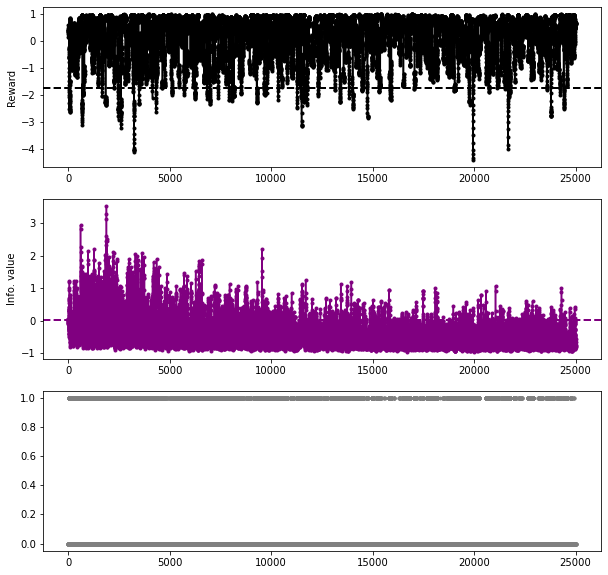

In [29]:
agent = "agent_0"
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

times = np.arange(0, len(total_rewards[agent]))

ax1.plot(times, total_rewards[agent], '.-', color="black", label="reward")
if do_fold:
    ax1.axhline(
        env.reference_reward[agent].mean(), 
        color='black', 
        linestyle='dashed', 
        linewidth=2
    )
ax1.set_ylabel("Reward")
# ax1.set_ylim(-10, 10)
# ax2.semilogy()

times = np.arange(0, len(total_infovals[agent]))
ax2.plot(times, total_infovals[agent], '.-', color="purple", label="intrinsic")
if do_fold:
    ax2.axhline(
        academic.reference_reward[agent].mean(), 
        color='purple', 
        linestyle='dashed', 
        linewidth=2
    )
ax2.set_ylabel("Info. value")
# ax2.semilogy()
# ax2.set_ylim(-10, 10)

# mimic WSLS
eta = 0
meta = []
rewards = np.asarray(total_rewards[agent])
infovals = np.asarray(total_infovals[agent])
meta = (infovals - eta) > rewards
print(rewards)
times = np.arange(0, len(meta))
ax3.plot(times, meta, '.', color="grey", label="WSLS")